# SHAP for 4-Week Model

Gaylen Fronk  
June 3, 2024

In [ ]:
study <- "match"
version <- "v6"
y_col_name <- "pp_hybrid_wk4_outcome"


In [ ]:

# packages for script
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:
# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_data <- str_c("P:/studydata/match/chtc/", y_col_name)},
        
        # IOS paths
        Darwin = {
          path_data <- str_c("/Volumes/private/studydata/match/chtc/", y_col_name)},
        
        # Linux paths
        Linux = {
          path_data <- str_c("~/mnt/private/studydata/match/chtc/", y_col_name)}
)


In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)


## Read in data

SHAP obtained with LOOCV at CHTC

In [ ]:
local <- read_csv(file.path(path_data, str_c("shap_loocv_", version), 
                            "output", "batch_results.csv"),
                  col_types = "cddd")

glimpse(local)


Rows: 1,272,852
Columns: 4
$ variable_name  <chr> "age_1st_cig", "age_daily_smoker", "age_ehr", "alc_bing…
$ variable_value <dbl> 0.18140, -0.56780, 0.57420, 0.70530, 1.41800, -0.02156,…
$ contribution   <dbl> 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,…
$ subid          <dbl> 51514, 51514, 51514, 51514, 51514, 51514, 51514, 51514,…

This dataset is already local SHAP values because we have one observation per subid per variable.

## Get global Shapley values

In [ ]:
global <- local |> 
  mutate(abs_contribution = abs(contribution)) |> 
  group_by(variable_name) |> 
  summarize(mean_contribution = mean(abs_contribution)) |> 
  arrange(desc(mean_contribution))

glimpse(global)


Rows: 1,173
Columns: 2
$ variable_name     <chr> "co", "race_ehr_white", "wisdm37_2_item_order", "mot…
$ mean_contribution <dbl> 0.029854168, 0.023656426, 0.018174897, 0.016328284, …

Delineate treatment interactions

In [ ]:
global <- global |> 
  mutate(tx_int = if_else(str_detect(variable_name, "treatment_"), "Interaction", "Main Effect"))

local <- local |> 
  mutate(tx_int = if_else(str_detect(variable_name, "treatment_"), "Interaction", "Main Effect"))


## Make global figures

Overall

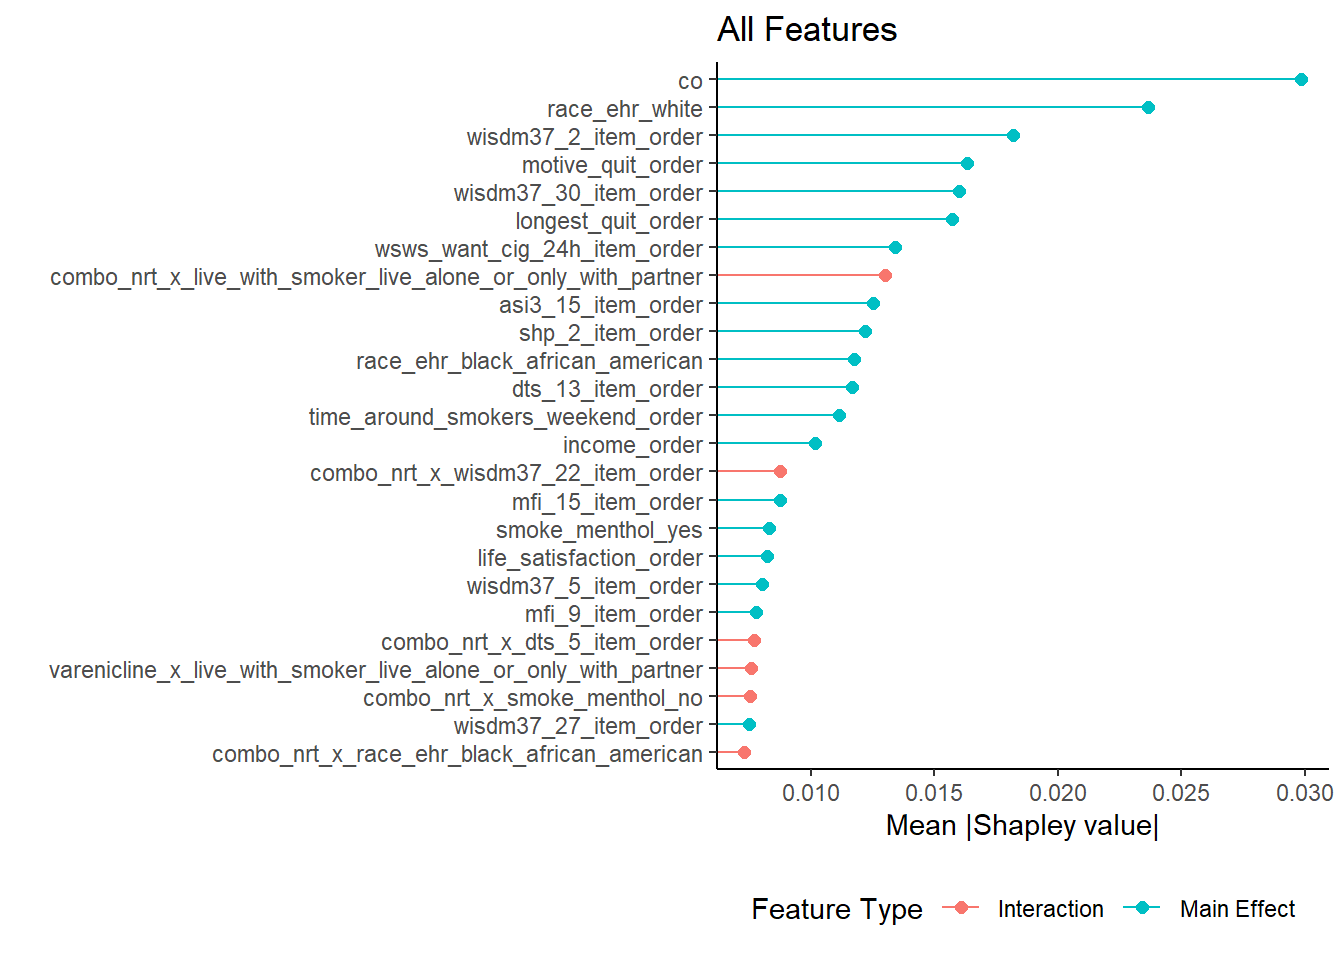

In [ ]:
fig_shap_global <- global |> 
  arrange(desc(mean_contribution)) |> 
  slice(1:25) |> 
  arrange(mean_contribution) |> 
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  mutate(variable_name = fct_inorder(variable_name)) |> 
  ggplot(mapping = aes(x = variable_name, y = mean_contribution, color = tx_int)) +
  geom_point(size = 2) +
  geom_segment(aes(x = variable_name, y = mean_contribution, xend = variable_name),
               yend = 0) +
  labs(
    x = "",
    y = "Mean |Shapley value|",
    color = "Feature Type",
    title = "All Features"
  ) +
  coord_flip() +
  theme(legend.position = "bottom")

fig_shap_global


Global Shapley values among treatment interactions

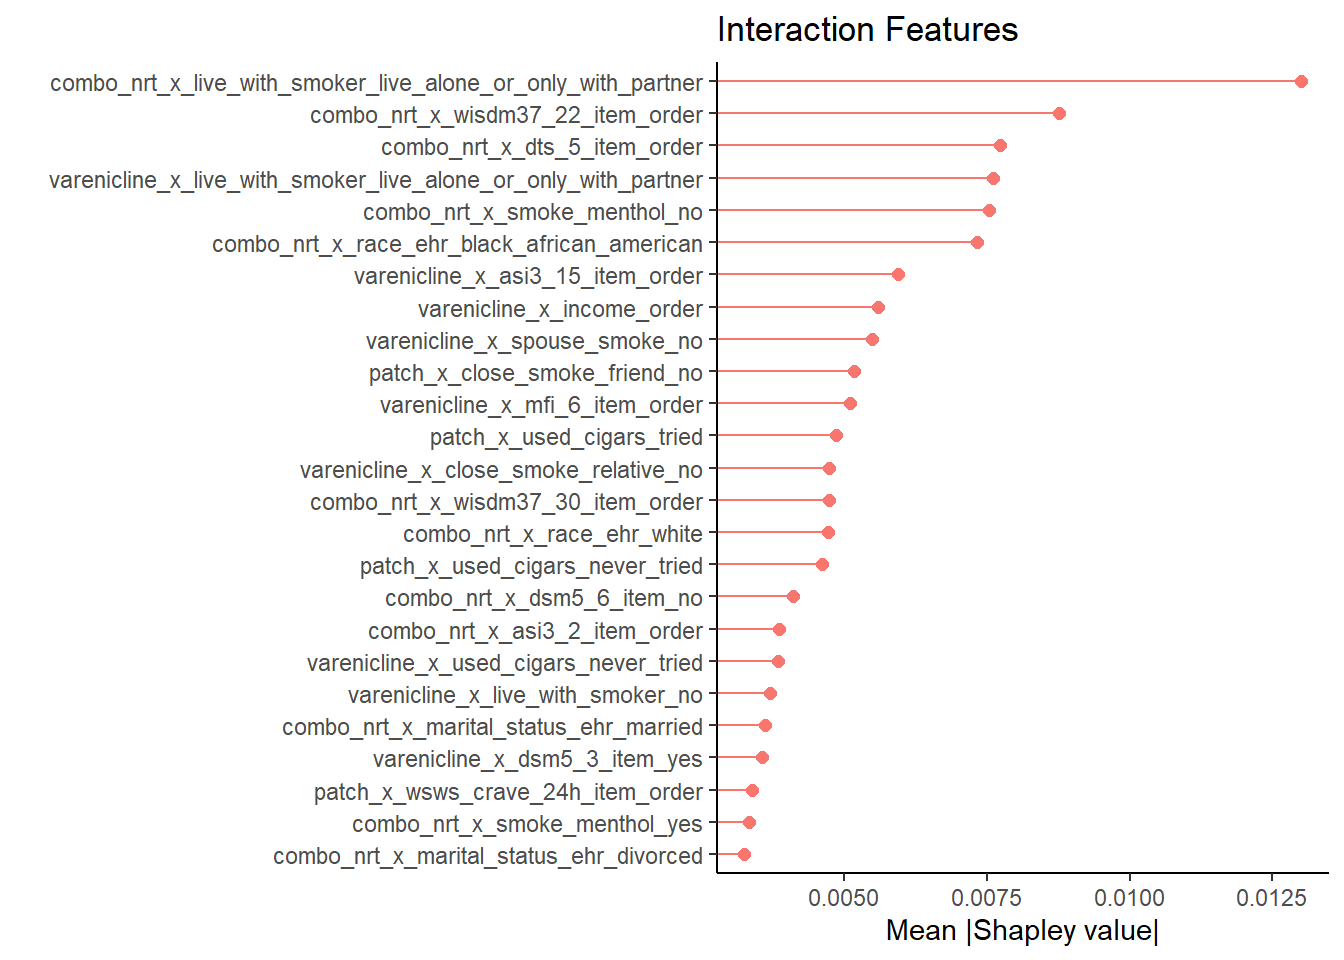

In [ ]:
fig_shap_global_tx <- global |> 
  filter(tx_int == "Interaction") |> 
  arrange(desc(mean_contribution)) |> 
  slice(1:25) |> 
  arrange(mean_contribution) |> 
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  mutate(variable_name = fct_inorder(variable_name)) |> 
  ggplot(mapping = aes(x = variable_name, y = mean_contribution, color = tx_int)) +
  geom_point(size = 2) +
  geom_segment(aes(x = variable_name, y = mean_contribution, xend = variable_name),
               yend = 0) +
  labs(
    x = "",
    y = "Mean |Shapley value|",
    title = "Interaction Features"
  ) +
  coord_flip() +
  theme(legend.position = "none")

fig_shap_global_tx


Paneled Global figure

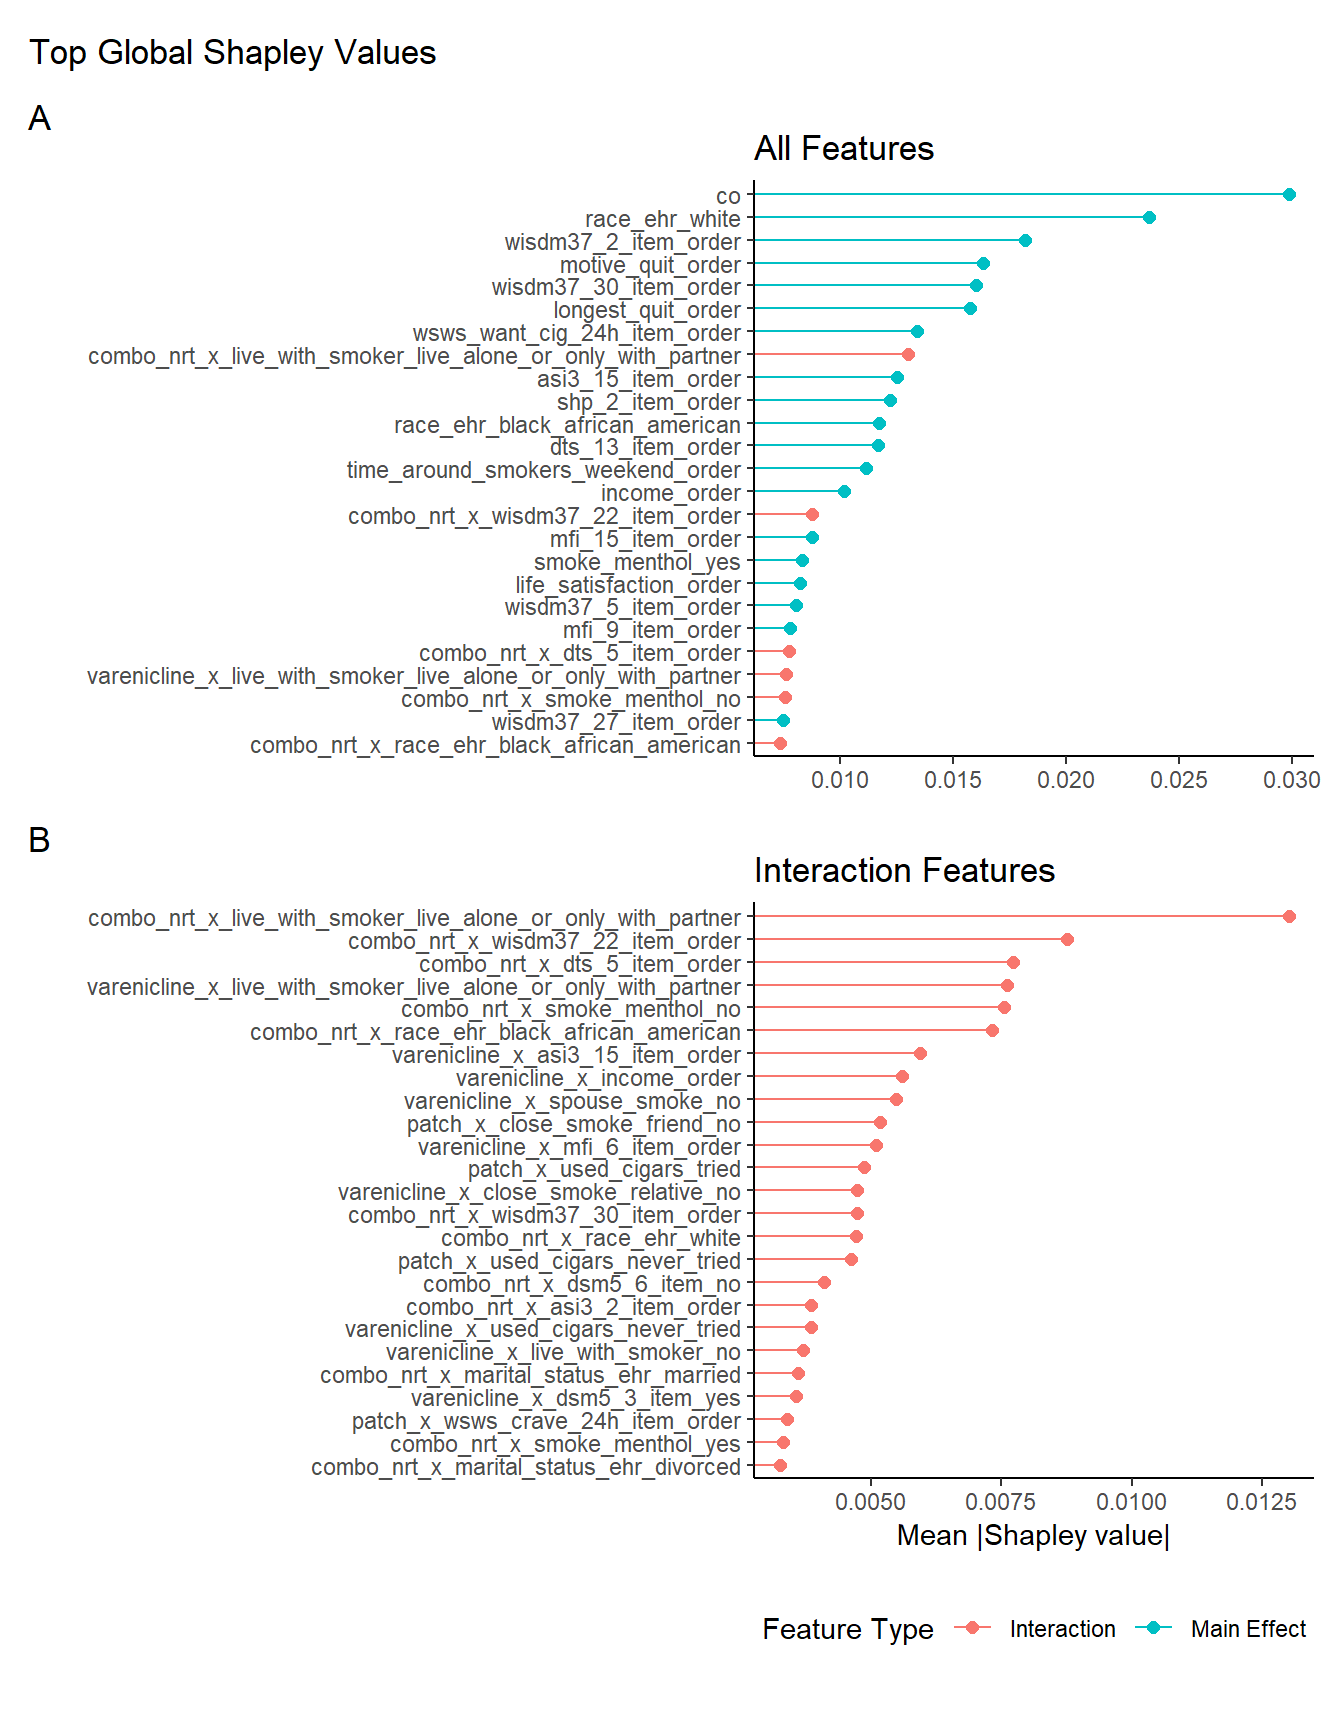

In [ ]:
#|
fig_panel_shap_global <- (fig_shap_global / fig_shap_global_tx / guide_area()) +
  plot_layout(guides = "collect", axes = "collect", ncol = 1,
              heights = unit(c(3, 3, 0.5), "in")) +
  plot_annotation(tag_levels = "A",
                  title = "Top Global Shapley Values")

fig_panel_shap_global


## Make Sina plots (local)

Set up data

In [ ]:
local_fig <- global |>
  arrange(desc(mean_contribution)) |> 
  slice(1:25) |> 
  left_join(local, by = c("variable_name", "tx_int"))

local_fig_tx <- global |> 
  filter(tx_int == "Interaction") |> 
  arrange(desc(mean_contribution)) |> 
  slice(1:25) |> 
  left_join(local, by = c("variable_name", "tx_int"))


Overall

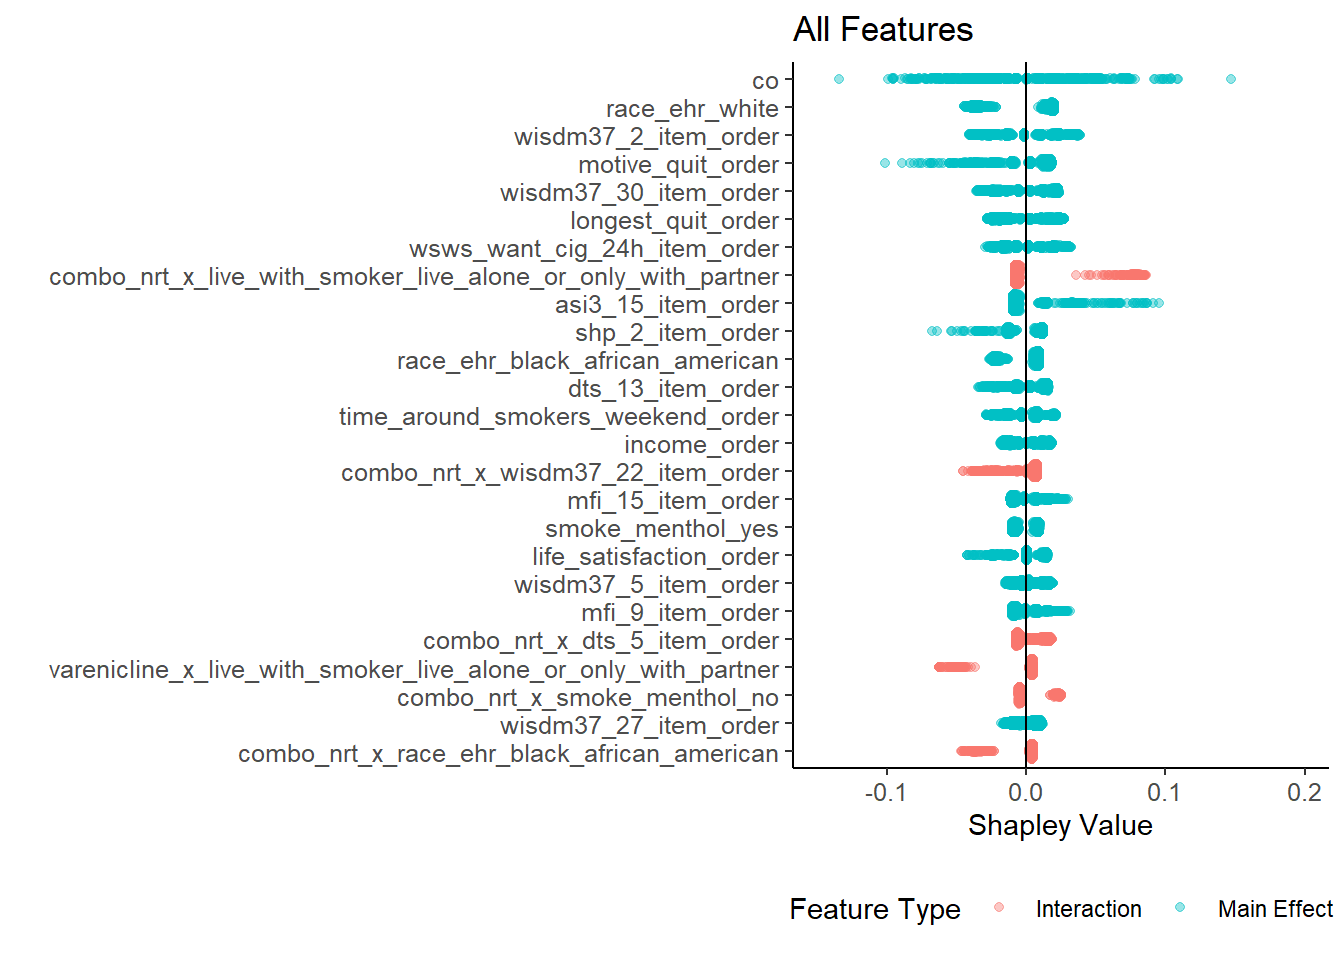

In [ ]:
fig_shap_local_all <- local_fig |>
  arrange(mean_contribution) |> 
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  mutate(variable_name = fct_inorder(variable_name)) |> 
  ggplot(mapping = aes(x = variable_name, y = contribution,
                       color = tx_int)) +
  ggforce::geom_sina(method = "counts", maxwidth = 0.7, alpha = 0.4) +
  geom_hline(yintercept = 0) +
  scale_y_continuous(limits = c(-0.15, 0.2)) +
  labs(
    x = "",
    y = "Shapley Value",
    color = "Feature Type",
    title = "All Features"
  ) +
  theme(axis.text = element_text(size = 9.5),
        legend.position = "bottom") +
  coord_flip()

fig_shap_local_all


Local Shapley values among treatment interactions

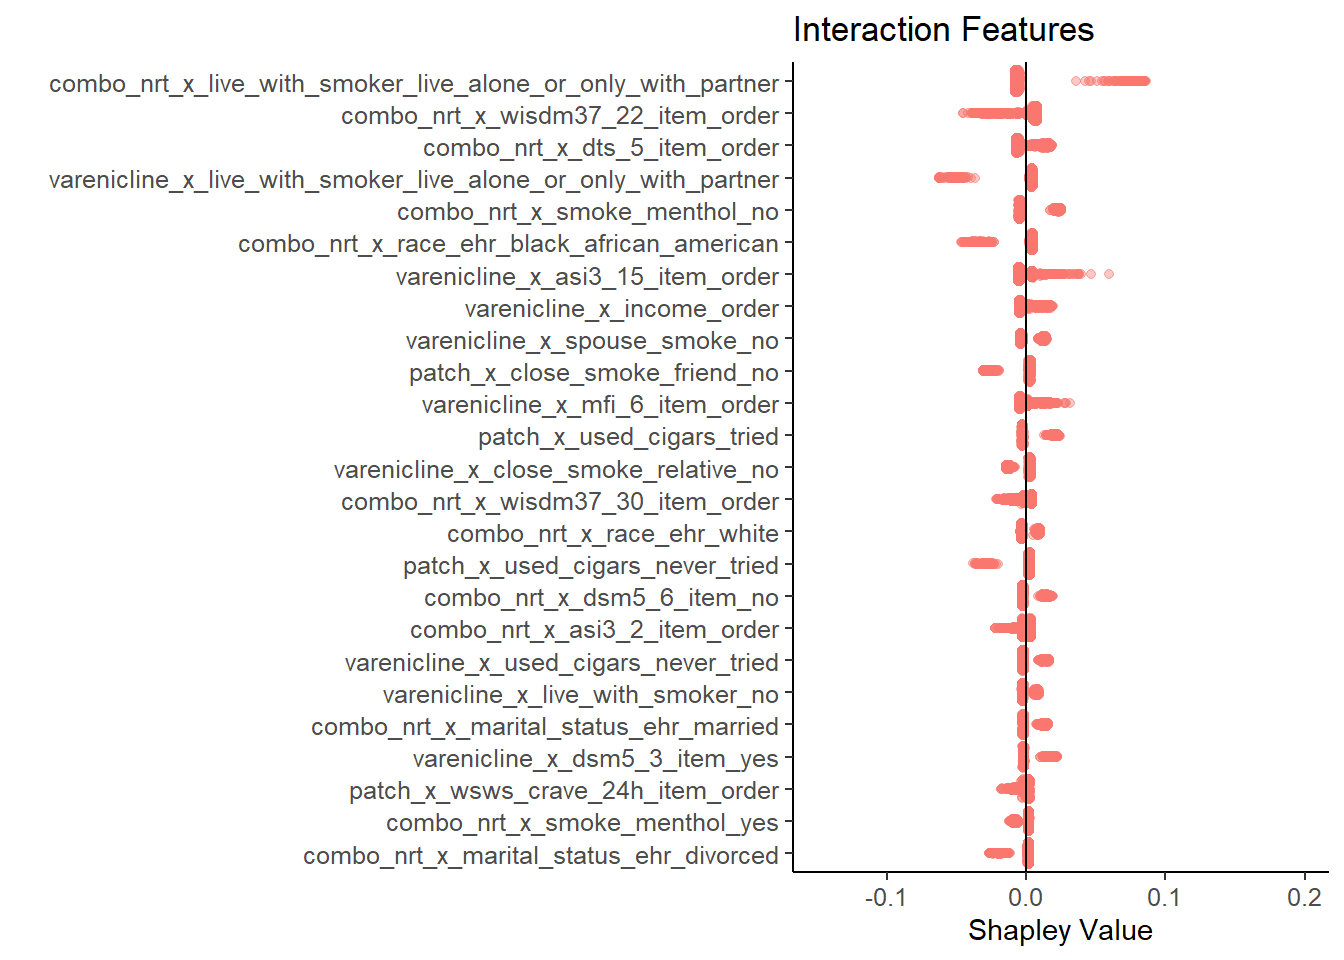

In [ ]:
fig_shap_local_tx <- local_fig_tx |> 
  arrange(mean_contribution) |> 
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  mutate(variable_name = fct_inorder(variable_name)) |> 
  ggplot(mapping = aes(x = variable_name, y = contribution,
                       color = tx_int)) +
  ggforce::geom_sina(method = "counts", maxwidth = 0.7, alpha = 0.4) +
  geom_hline(yintercept = 0) +
  scale_y_continuous(limits = c(-0.15, 0.2)) +
  labs(
    x = "",
    y = "Shapley Value",
    title = "Interaction Features"
  ) +
  theme(axis.text = element_text(size = 9.5),
        legend.position = "none") +
  coord_flip()

fig_shap_local_tx


Paneled local figure

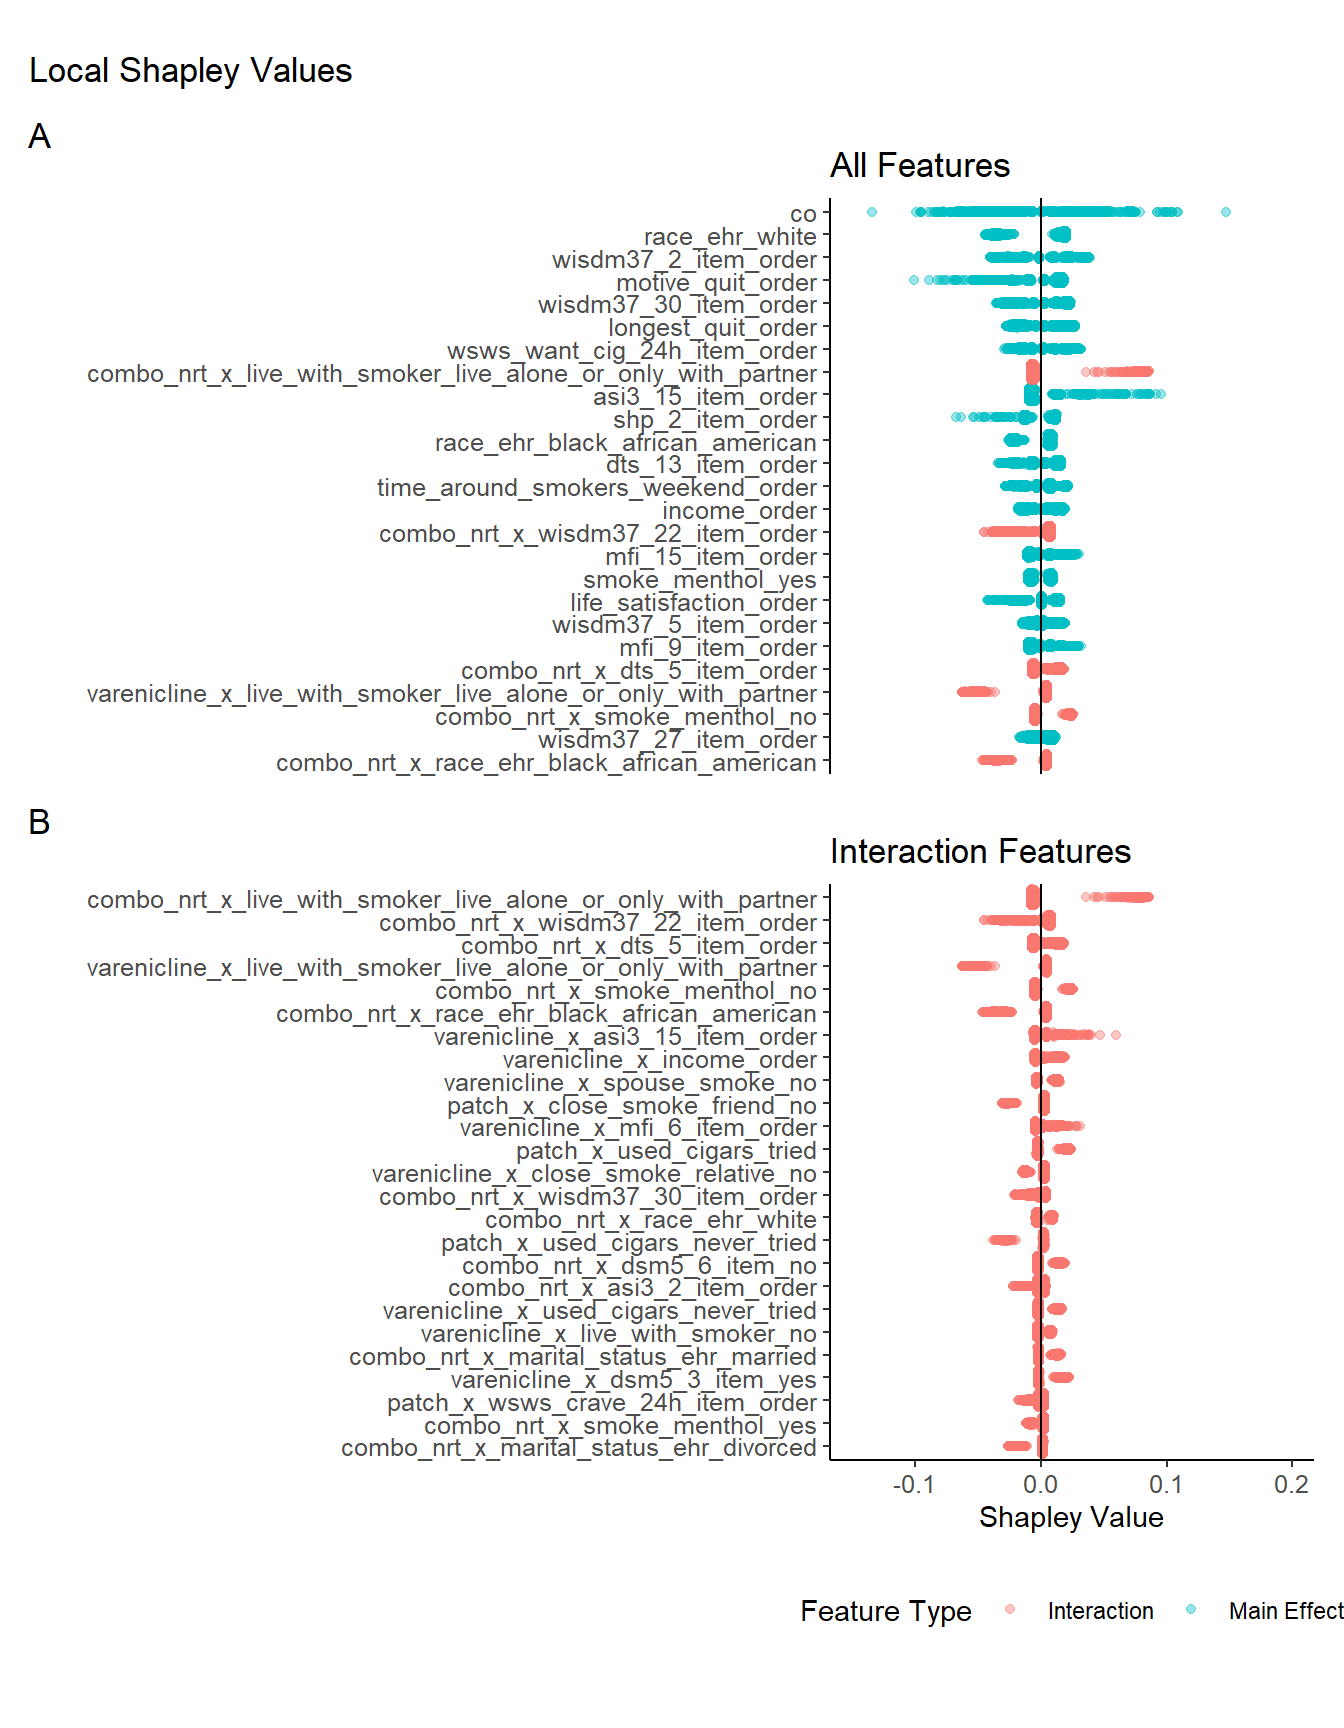

In [ ]:
#|
fig_panel_shap_local <- (fig_shap_local_all / fig_shap_local_tx / guide_area()) +
  plot_layout(guides = "collect", axes = "collect", ncol = 1,
              heights = unit(c(3, 3, 0.5), "in")) +
  plot_annotation(tag_levels = "A",
                  title = "Local Shapley Values")

fig_panel_shap_local
